# Intent classification using Convolutional Neural Networks

#### Importing libraries and setting parameters

In [18]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import Reshape, Dropout, Concatenate
from keras.layers import Conv2D, MaxPool2D, Embedding
from keras.models import Model

BASE_DIR = 'C:/Users/username/Documents/chatbot/textcnn'
GLOVE_DIR = BASE_DIR + '/glove.6B/'
TEXT_DATA_DIR = BASE_DIR + '/data/processed_data'
MAX_SEQUENCE_LENGTH = 50 # Maximum number of words in a sentence
MAX_NB_WORDS = 20000 # Vocabulary size
EMBEDDING_DIM = 100 # Dimensions of Glove word vectors 
VALIDATION_SPLIT = 0.10

#### loading and processing data

In [2]:
texts = np.load(open('data/train_text.npy', 'rb')).tolist()
labels = np.load(open('data/train_label.npy', 'rb')).tolist()

test_texts = np.load(open('data/test_text.npy', 'rb')).tolist()
test_labels = np.load(open('data/test_label.npy', 'rb')).tolist()

# Label Encoding: converting text labels into the integers
from sklearn import preprocessing

train_le = preprocessing.LabelEncoder()
train_le.fit(labels)

from sklearn.externals import joblib #Saving label encoder, we will need it later
joblib.dump(train_le, 'data/label_encoder.pkl') 

labels = train_le.transform(labels)
test_labels = train_le.transform(test_labels)

label_dict = dict(zip(list(train_le.classes_), train_le.transform(list(train_le.classes_))))
print(label_dict)

{'AddToPlaylist': 0, 'BookRestaurant': 1, 'GetWeather': 2, 'RateBook': 3, 'SearchCreativeWork': 4, 'SearchScreeningEvent': 5}


#### Tokenizing text and creating word index

In [3]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

print('Preparing embedding matrix.')

Found 9869 unique tokens.
Shape of data tensor: (11784, 50)
Shape of label tensor: (11784, 6)
Preparing embedding matrix.


#### Creating embedding matrix from Glove vectors.

 Specifically, we will use the 100-dimensional GloVe embeddings of 400k words computed on a 2014 dump of English Wikipedia. You can download them from http://nlp.stanford.edu/data/glove.6B.zip and extract it under the directory, BASE_DIR + '/glove.6B/'

In [4]:
print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [5]:
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

#### Model Creation

We will now try to build model described in "Convolutional Neural Networks for Sentence Classification
", https://arxiv.org/abs/1408.5882

It is highly recommended to read, "A Sensitivity Analysis of (and Practitioners' Guide to) Convolutional Neural Networks for Sentence Classification", https://arxiv.org/abs/1510.03820 to get an intuition behind the various hyperparameters chosen to build our model.

In [8]:
filter_sizes = [2,3,5]
num_filters = 512
drop = 0.5

print("Creating Model...")
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = Embedding(input_dim=len(word_index) + 1, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                      input_length=MAX_SEQUENCE_LENGTH, trainable=False)(inputs)
reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBEDDING_DIM), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBEDDING_DIM), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBEDDING_DIM), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
preds = Dense(len(label_dict), activation='softmax')(dropout)

# this creates a model that includes inputs and outputs
model = Model(inputs=inputs, outputs=preds)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()

Creating Model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 100)      987000      input_2[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 50, 100, 1)   0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 49, 1, 512)   102912      reshape_2[0][0]                  
___________________________________________________________________________________________

In [9]:
history = model.fit(x_train, y_train,
          batch_size=64,
          epochs=10,
          validation_data=(x_val, y_val))

Train on 10606 samples, validate on 1178 samples
Epoch 1/10
10606/10606 [==============================] - 12s 1ms/step - loss: 0.2478 - acc: 0.9183 - val_loss: 0.0527 - val_acc: 0.9881
Epoch 2/10
10606/10606 [==============================] - 11s 1ms/step - loss: 0.0564 - acc: 0.9839 - val_loss: 0.0370 - val_acc: 0.9898
Epoch 3/10
10606/10606 [==============================] - 11s 1ms/step - loss: 0.0325 - acc: 0.9911 - val_loss: 0.0319 - val_acc: 0.9898
Epoch 4/10
10606/10606 [==============================] - 11s 1ms/step - loss: 0.0201 - acc: 0.9952 - val_loss: 0.0235 - val_acc: 0.9932
Epoch 5/10
10606/10606 [==============================] - 12s 1ms/step - loss: 0.0147 - acc: 0.9959 - val_loss: 0.0225 - val_acc: 0.9915
Epoch 6/10
10606/10606 [==============================] - 11s 1ms/step - loss: 0.0117 - acc: 0.9968 - val_loss: 0.0278 - val_acc: 0.9924
Epoch 7/10
10606/10606 [==============================] - 11s 1ms/step - loss: 0.0088 - acc: 0.9975 - val_loss: 0.0262 - val_acc:

Wow! That looks amazing! 99 % and 98 % accuracy on train and validation dataset respectively within a minute after 3 epochs!

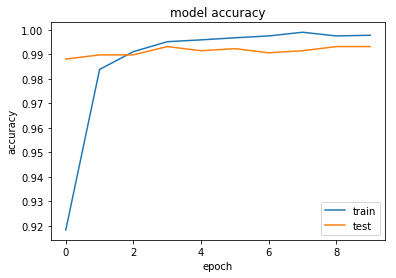

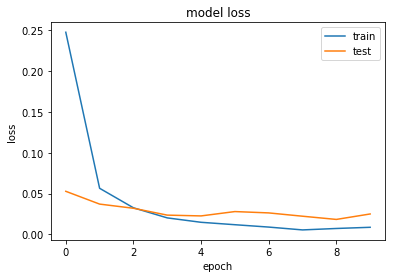

In [16]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#### Test dataset evaluation

In [11]:
# Processing text to be compatible with model input

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_input = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Get predictions
test_predictions_probas = model.predict(test_input)
test_predictions = test_predictions_probas.argmax(axis=-1)

In [12]:
from sklearn.metrics import classification_report

test_intent_predictions = train_le.inverse_transform(test_predictions)
test_intent_original = train_le.inverse_transform(test_labels)

print('accuracy: ', sum(test_intent_predictions == test_intent_original) / len(test_labels))
print("Precision, Recall and F1-Score:\n\n", classification_report(test_intent_original, test_intent_predictions))

accuracy:  0.9866666666666667
Precision, Recall and F1-Score:

                       precision    recall  f1-score   support

       AddToPlaylist       1.00      1.00      1.00       100
      BookRestaurant       1.00      1.00      1.00       100
          GetWeather       1.00      0.98      0.99       100
            RateBook       1.00      1.00      1.00       100
  SearchCreativeWork       0.95      0.99      0.97       100
SearchScreeningEvent       0.97      0.95      0.96       100

         avg / total       0.99      0.99      0.99       600



C:\Users\ajinkya\Documents\chatbot\chatbot_env\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ajinkya\Documents\chatbot\chatbot_env\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


So we saw how we can reach 99% accuracy using Convolutional Neural Network for our intent classification task within a minute!